In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import KFold

In [2]:
df=pd.read_csv("formatted_combined_dataset.csv",usecols=["Abstract","Class"])

In [3]:
df.head()

,Abstract,Class
0,The paper provides unusual approach towards th...,Sociology
1,An introduction to the work of the greatest Ge...,Sociology
2,The joint JAXA/NASA ASTRO-H mission is the six...,Astronomy
3,The category of astronomical time is only one ...,Sociology
4,"In a choice among assured, familiar outcomes o...",Psychology


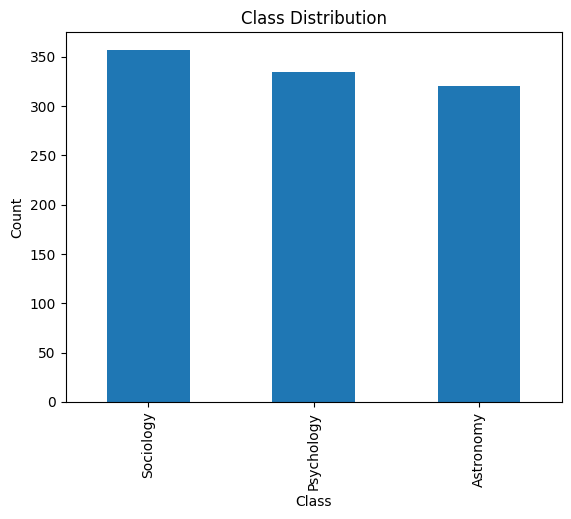

In [4]:


# Assuming df['Class'] contains your class labels.
class_counts = df['Class'].value_counts()

# Bar plot
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()


In [5]:
label_map = {'Astronomy': 0,  'Psychology': 1, 'Sociology': 2}
df['label'] = df['Class'].map(label_map)



In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

c:\Users\Laptop\Desktop\AI Training\AI_Training\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
len(train),len(test),len(val)
train.head()

,Abstract,Class,label
500,We present a new catalogue of blazars based on...,Astronomy,0
163,Psychology faces a replication crisis. The Rep...,Psychology,1
433,"The clinician looking, listening, or feeling f...",Psychology,1
804,An examination of the title of Alvin Gouldner'...,Sociology,2
330,"Imagined futures, once a vital topic of theore...",Sociology,2


In [8]:

def df_to_dataset(dataframe, shuffle=True, batch_size=16):
    # Make a copy to avoid altering the original DataFrame
    df = dataframe.copy()

    # Extract labels and ensure they are in a NumPy array with consistent dtype
    labels = df.pop('label').values
    labels=tf.one_hot(labels,depth=3)

    # Extract and convert 'Abstract' to strings (ensures compatibility with TensorFlow)
    abstracts = df["Abstract"].astype(str).values

    # Create a TensorFlow dataset
    ds = tf.data.Dataset.from_tensor_slices((abstracts, labels))

    # Shuffle, batch, and prefetch the data for optimized input pipeline
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [9]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)
dataset=df_to_dataset(df)


In [10]:
for batch in train_data.take(1):  # Take 1 batch
    abstracts, labels = batch
    print(abstracts.shape, labels.shape)  # Check shapes for both inputs and labels


(16,) (16, 3)


In [11]:

hub_layer =hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1",
                           input_shape=[], dtype=tf.string)

In [12]:

hub_layer(list(train_data)[0][0])# Check if hub_layer is an instance of tf.keras.layers


<tf.Tensor: shape=(16, 50), dtype=float32, numpy=
array([[ 2.97494262e-01,  2.44592890e-01,  4.72754478e-01,
         8.51092875e-01, -5.99421024e-01, -3.93067032e-01,
         6.73230439e-02, -5.83716528e-03, -6.15339816e-01,
        -1.51324393e-02, -2.47217953e-01,  3.83418530e-01,
        -2.94682384e-01, -4.51724052e-01, -3.27152237e-02,
        -2.55886018e-01,  1.98851198e-01, -4.37943250e-01,
         4.74826217e-01,  7.52981752e-02, -2.68322796e-01,
        -2.96765774e-01,  4.28149790e-01, -2.17898175e-01,
        -1.96856514e-01, -1.76600218e-02, -1.93741977e-01,
         3.25068951e-01,  6.96555823e-02, -2.85262704e-01,
        -9.18635577e-02, -1.96757108e-01, -8.24523717e-02,
        -4.75155383e-01, -3.97380531e-01, -6.99065983e-01,
         1.77753240e-01, -4.00561601e-01, -6.34341463e-02,
        -4.01244104e-01, -9.81652811e-02, -1.05763145e-01,
        -1.21470310e-01,  7.25755811e-01,  1.11223713e-01,
        -2.44046718e-01, -9.65793505e-02, -3.76981907e-02,
      

In [13]:
model = tf.keras.Sequential()
num_classes=3

hub_layer_wrapper = tf.keras.layers.Lambda(lambda x: hub_layer(x))
model.add(hub_layer_wrapper)
model.add(tf.keras.layers.Dense(16, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [14]:
target = tf.one_hot(train["label"], depth=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
model.evaluate(train_data)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


51/51 [==============================] - 1s 3ms/step - loss: 1.2180 - accuracy: 0.3288


[1.2179850339889526, 0.3288009762763977]

In [16]:
model.evaluate(valid_data)

7/7 [==============================] - 0s 2ms/step - loss: 1.2363 - accuracy: 0.3366


[1.2363001108169556, 0.3366336524486542]

In [21]:
# Correct use of matplotlib's ylabel function
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

# Custom callback to compute and plot confusion matrix and classification report
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super().__init__()
        self.valid_data = valid_data  # Passing the validation data during initialization

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_labels = []
        
        # Iterate through validation data to get the predictions
        for x_batch, y_batch in self.valid_data:
            predictions = np.argmax(self.model(x_batch), axis=1)
            val_preds.extend(predictions)
            val_labels.extend(np.argmax(y_batch, axis=1))
        
        # Calculate confusion matrix and classification report
        cm = confusion_matrix(val_labels, val_preds)
        cr = classification_report(val_labels, val_preds, target_names=["Class 0", "Class 1", "Class 2"])
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
        plt.ylabel('Actual')   # Check that plt.ylabel has not been redefined
        plt.xlabel('Predicted')  # Check that plt.xlabel has not been redefined
        plt.title(f"Confusion Matrix - Epoch {epoch+1}")
        plt.show()

        # Print classification report
        print(f"\nClassification Report for Epoch {epoch+1}:\n", cr)


# Ensure plt is properly used for plotting labels
import matplotlib.pyplot as plt


Epoch 1/5
50/51 [============================>.] - ETA: 0s - loss: 1.0224 - accuracy: 0.5088

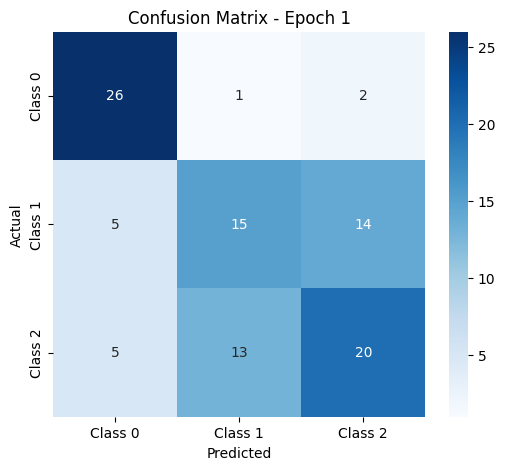


Classification Report for Epoch 1:
               precision    recall  f1-score   support

     Class 0       0.72      0.90      0.80        29
     Class 1       0.52      0.44      0.48        34
     Class 2       0.56      0.53      0.54        38

    accuracy                           0.60       101
   macro avg       0.60      0.62      0.61       101
weighted avg       0.59      0.60      0.59       101

51/51 [==============================] - 1s 26ms/step - loss: 1.0212 - accuracy: 0.5105 - val_loss: 0.9946 - val_accuracy: 0.6040
Epoch 2/5
50/51 [============================>.] - ETA: 0s - loss: 0.9349 - accuracy: 0.5938

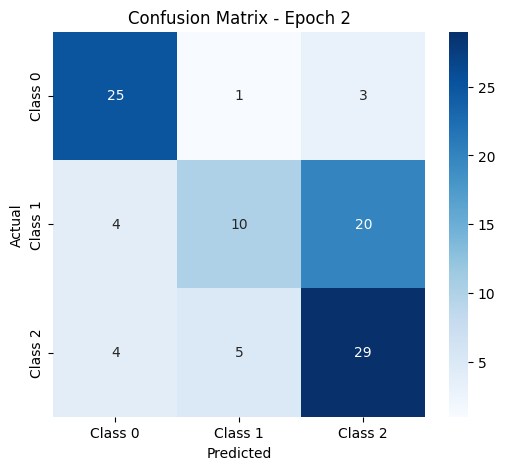


Classification Report for Epoch 2:
               precision    recall  f1-score   support

     Class 0       0.76      0.86      0.81        29
     Class 1       0.62      0.29      0.40        34
     Class 2       0.56      0.76      0.64        38

    accuracy                           0.63       101
   macro avg       0.65      0.64      0.62       101
weighted avg       0.64      0.63      0.61       101

51/51 [==============================] - 1s 28ms/step - loss: 0.9337 - accuracy: 0.5946 - val_loss: 0.8997 - val_accuracy: 0.6337
Epoch 3/5
51/51 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.6230

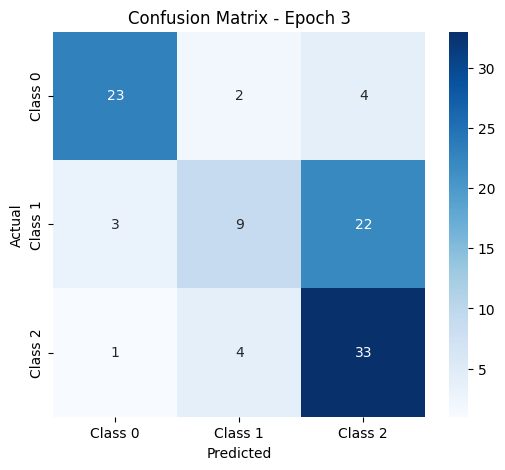


Classification Report for Epoch 3:
               precision    recall  f1-score   support

     Class 0       0.85      0.79      0.82        29
     Class 1       0.60      0.26      0.37        34
     Class 2       0.56      0.87      0.68        38

    accuracy                           0.64       101
   macro avg       0.67      0.64      0.62       101
weighted avg       0.66      0.64      0.62       101

51/51 [==============================] - 1s 27ms/step - loss: 0.8295 - accuracy: 0.6230 - val_loss: 0.8039 - val_accuracy: 0.6436
Epoch 4/5
49/51 [===========================>..] - ETA: 0s - loss: 0.7431 - accuracy: 0.6543

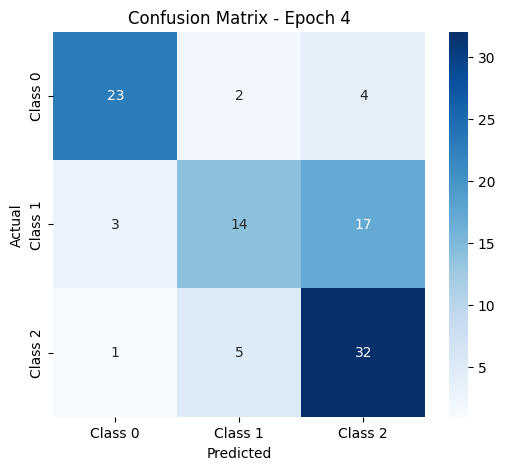


Classification Report for Epoch 4:
               precision    recall  f1-score   support

     Class 0       0.85      0.79      0.82        29
     Class 1       0.67      0.41      0.51        34
     Class 2       0.60      0.84      0.70        38

    accuracy                           0.68       101
   macro avg       0.71      0.68      0.68       101
weighted avg       0.70      0.68      0.67       101

51/51 [==============================] - 1s 26ms/step - loss: 0.7437 - accuracy: 0.6539 - val_loss: 0.7435 - val_accuracy: 0.6832
Epoch 5/5
50/51 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.6800

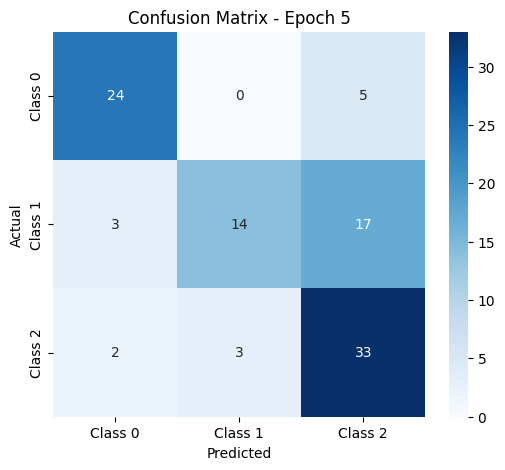


Classification Report for Epoch 5:
               precision    recall  f1-score   support

     Class 0       0.83      0.83      0.83        29
     Class 1       0.82      0.41      0.55        34
     Class 2       0.60      0.87      0.71        38

    accuracy                           0.70       101
   macro avg       0.75      0.70      0.70       101
weighted avg       0.74      0.70      0.69       101

51/51 [==============================] - 1s 26ms/step - loss: 0.6867 - accuracy: 0.6811 - val_loss: 0.7047 - val_accuracy: 0.7030


In [22]:

history=model.fit(train_data,epochs=5,validation_data=valid_data,callbacks=[ConfusionMatrixCallback(valid_data)])

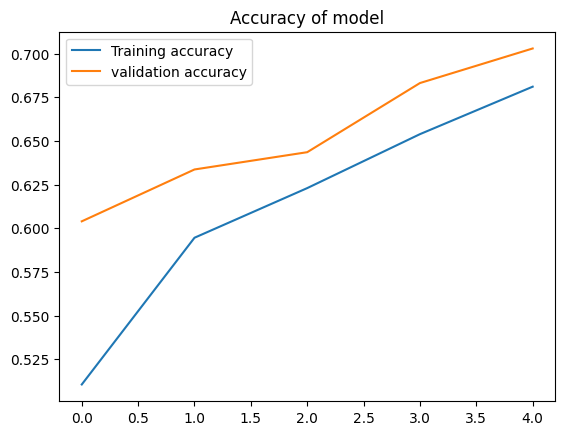

In [23]:
plt.plot(history.history["accuracy"],label="Training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.title("Accuracy of model")
plt.ylabel=("Accuracy")
plt.xlabel=("Epoch")
plt.legend()
plt.show()

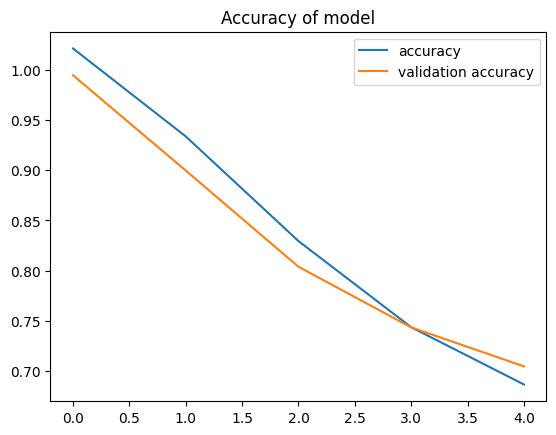

In [24]:
plt.plot(history.history["loss"],label="accuracy")
plt.plot(history.history["val_loss"],label="validation accuracy")
plt.title("Accuracy of model")
plt.ylabel=("Accuracy")
plt.xlabel=("Epoch")
plt.legend()
plt.show()

In [25]:
model.evaluate(test_data)

7/7 [==============================] - 0s 20ms/step - loss: 0.6050 - accuracy: 0.6961


[0.6049540042877197, 0.6960784196853638]


Training Fold 1/5
Epoch 1/5
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


21/21 [==============================] - 1s 30ms/step - loss: 1.1536 - accuracy: 0.3400 - val_loss: 1.0825 - val_accuracy: 0.4136
Epoch 2/5
21/21 [==============================] - 1s 25ms/step - loss: 1.0824 - accuracy: 0.3957 - val_loss: 1.0531 - val_accuracy: 0.4568
Epoch 3/5
21/21 [==============================] - 1s 24ms/step - loss: 1.0407 - accuracy: 0.4637 - val_loss: 1.0146 - val_accuracy: 0.5370
Epoch 4/5
21/21 [==============================] - 1s 24ms/step - loss: 0.9955 - accuracy: 0.5518 - val_loss: 0.9697 - val_accuracy: 0.6049
Epoch 5/5
6/6 [==============================] - 0s 18ms/step

Classification Report for Fold 1
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        50
           1       0.56      0.50      0.53        48
           2       0.59      0.78      0.67        64

    accuracy                           0.67       162
   macro avg       0.72      0.65      0.67       162
weighted avg       0.71     

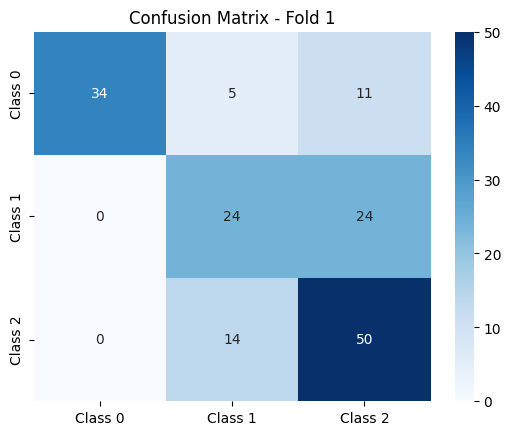


Training Fold 2/5
Epoch 1/5
The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


21/21 [==============================] - 1s 30ms/step - loss: 1.0980 - accuracy: 0.3369 - val_loss: 1.0835 - val_accuracy: 0.3951
Epoch 2/5
21/21 [==============================] - 0s 24ms/step - loss: 1.0665 - accuracy: 0.5255 - val_loss: 1.0483 - val_accuracy: 0.5988
Epoch 3/5
21/21 [==============================] - 0s 24ms/step - loss: 1.0215 - accuracy: 0.6414 - val_loss: 0.9882 - val_accuracy: 0.6420
Epoch 4/5
21/21 [==============================] - 0s 24ms/step - loss: 0.9495 - accuracy: 0.6816 - val_loss: 0.9028 - val_accuracy: 0.6790
Epoch 5/5
6/6 [==============================] - 0s 18ms/step

Classification Report for Fold 2
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.56      0.69      0.62        52
           2       0.73      0.50      0.59        60

    accuracy                           0.69       162
   macro avg       0.69      0.70      0.69       162
weighted avg       0.70     

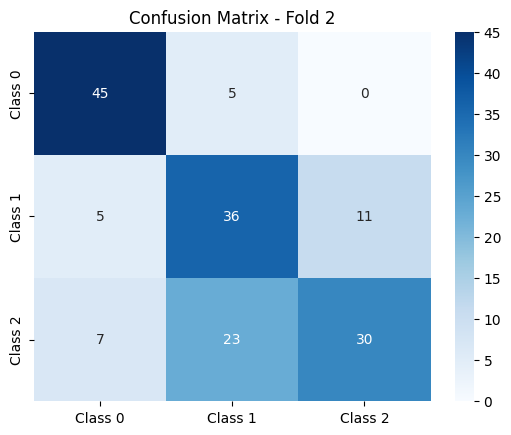


Training Fold 3/5
Epoch 1/5
The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


21/21 [==============================] - 1s 30ms/step - loss: 1.0820 - accuracy: 0.4173 - val_loss: 1.0840 - val_accuracy: 0.4444
Epoch 2/5
21/21 [==============================] - 0s 24ms/step - loss: 1.0263 - accuracy: 0.5518 - val_loss: 1.0280 - val_accuracy: 0.5679
Epoch 3/5
21/21 [==============================] - 1s 25ms/step - loss: 0.9627 - accuracy: 0.6244 - val_loss: 0.9645 - val_accuracy: 0.6543
Epoch 4/5
21/21 [==============================] - 0s 24ms/step - loss: 0.8872 - accuracy: 0.6677 - val_loss: 0.8997 - val_accuracy: 0.6481
Epoch 5/5
6/6 [==============================] - 0s 17ms/step

Classification Report for Fold 3
              precision    recall  f1-score   support

           0       0.77      0.84      0.81        57
           1       0.50      0.61      0.55        44
           2       0.76      0.57      0.65        61

    accuracy                           0.68       162
   macro avg       0.68      0.68      0.67       162
weighted avg       0.69     

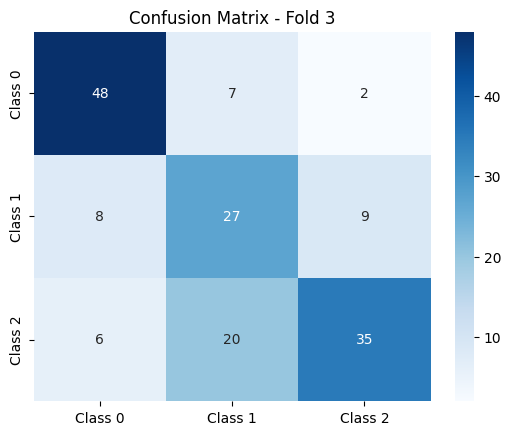


Training Fold 4/5
Epoch 1/5
The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


21/21 [==============================] - 1s 30ms/step - loss: 1.0830 - accuracy: 0.3895 - val_loss: 1.0837 - val_accuracy: 0.2963
Epoch 2/5
21/21 [==============================] - 0s 24ms/step - loss: 1.0071 - accuracy: 0.4204 - val_loss: 1.0110 - val_accuracy: 0.3951
Epoch 3/5
21/21 [==============================] - 1s 24ms/step - loss: 0.9264 - accuracy: 0.5657 - val_loss: 0.9132 - val_accuracy: 0.5741
Epoch 4/5
21/21 [==============================] - 0s 24ms/step - loss: 0.8567 - accuracy: 0.6275 - val_loss: 0.8367 - val_accuracy: 0.5988
Epoch 5/5
6/6 [==============================] - 0s 18ms/step

Classification Report for Fold 4
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        61
           1       0.72      0.38      0.49        61
           2       0.48      0.80      0.60        40

    accuracy                           0.69       162
   macro avg       0.70      0.70      0.67       162
weighted avg       0.72     

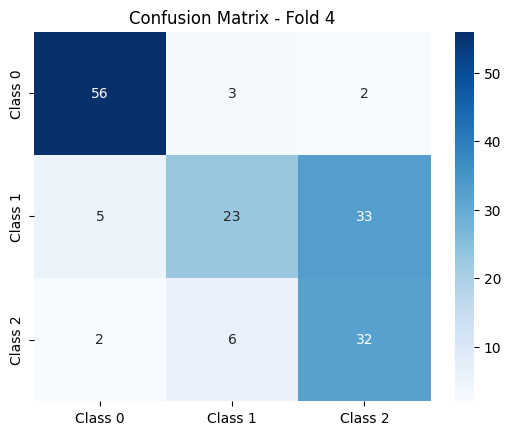


Training Fold 5/5
Epoch 1/5
The following Variables were used a Lambda layer's call (lambda_5), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda_5), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


21/21 [==============================] - 1s 30ms/step - loss: 1.0860 - accuracy: 0.3627 - val_loss: 1.0528 - val_accuracy: 0.3975
Epoch 2/5
21/21 [==============================] - 0s 24ms/step - loss: 1.0394 - accuracy: 0.4182 - val_loss: 1.0164 - val_accuracy: 0.4720
Epoch 3/5
21/21 [==============================] - 1s 24ms/step - loss: 1.0019 - accuracy: 0.5170 - val_loss: 0.9789 - val_accuracy: 0.5839
Epoch 4/5
21/21 [==============================] - 1s 24ms/step - loss: 0.9603 - accuracy: 0.5818 - val_loss: 0.9337 - val_accuracy: 0.6087
Epoch 5/5
6/6 [==============================] - 0s 17ms/step

Classification Report for Fold 5
              precision    recall  f1-score   support

           0       0.91      0.74      0.82        43
           1       0.59      0.56      0.57        61
           2       0.60      0.72      0.66        57

    accuracy                           0.66       161
   macro avg       0.70      0.67      0.68       161
weighted avg       0.68     

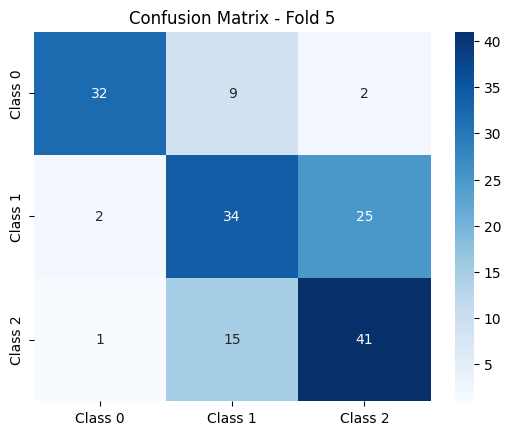


Average Accuracy across all folds: 0.676129138469696
Average Loss across all folds: 0.8346967339515686


In [26]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_data and valid_data are your datasets
num_folds = 5  # Set the number of folds for cross-validation

# Convert tf.data.Dataset into numpy arrays for usage with KFold
def dataset_to_numpy(dataset):
    X = []
    y = []
    for x_batch, y_batch in dataset:
        X.append(x_batch.numpy())
        y.append(y_batch.numpy())
    
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

# Recreate the model for each fold
def create_model():
    model = tf.keras.Sequential()
    num_classes = 3
    hub_layer_wrapper = tf.keras.layers.Lambda(lambda x: hub_layer(x))  # If using Hub layer
    model.add(hub_layer_wrapper)  # If you use an embedding from TensorFlow Hub
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert train_data to numpy arrays
X_train, y_train = dataset_to_numpy(train_data)

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Track fold performance metrics
fold_accuracies = []
fold_losses = []

for fold, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
    print(f"\nTraining Fold {fold + 1}/{num_folds}")
    
    # Split the data into training and validation subsets for this fold
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]
    
    # Convert the split data back into TensorFlow datasets
    train_data_fold = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(32)
    val_data_fold = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(32)
    
    # Create the model each time (important to re-initialize to avoid weight sharing across folds)
    model = create_model()
    
    # Train the model on the fold's data
    history = model.fit(
        train_data_fold,
        epochs=5,
        validation_data=val_data_fold,
        verbose=1
    )
    
    # Track the metrics for this fold
    fold_accuracies.append(history.history['val_accuracy'][-1])  # Validate accuracy for this fold
    fold_losses.append(history.history['val_loss'][-1])  # Validation loss for this fold

    # Optionally, display classification report for this fold
    y_pred = np.argmax(model.predict(X_val_fold), axis=-1)
    print("\nClassification Report for Fold", fold + 1)
    print(classification_report(np.argmax(y_val_fold, axis=-1), y_pred))
    
    # Visualize confusion matrix for this fold
    cm = confusion_matrix(np.argmax(y_val_fold, axis=-1), y_pred)
    print("Confusion Matrix for Fold", fold + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
    
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Average performance across all folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)

print(f"\nAverage Accuracy across all folds: {average_accuracy}")
print(f"Average Loss across all folds: {average_loss}")
